In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
import json
import shap

sns.set_theme(style="whitegrid")
print("Libraries loaded.")

Libraries loaded.


In [28]:
ROOT_DIR = '.'
FOLDER_IGNORE = ['.git', '.vscode']

# Searches for all folders (each folder is a IDS)
try:
    all_subdirs = [d.name for d in os.scandir(ROOT_DIR) if d.is_dir()]
    ids_project_folders = [
        d for d in all_subdirs
        if d not in FOLDER_IGNORE and os.path.exists(os.path.join(ROOT_DIR, d, 'src'))
    ]
except FileNotFoundError:
    print(f"ERROR: '{os.path.abspath(ROOT_DIR)}' not fiund.")
    ids_project_folders = []

if not ids_project_folders:
    print("No IDS projects found. Please check your folder structure.")
else:
    print("IDS projects found:")
    for folder in ids_project_folders:
        print(f"- {folder}")

AVISO: Nenhum arquivo de métricas (.csv) encontrado. Verifique o caminho e os resultados dos seus experimentos.


### analysis 1: comparative perfomance metrics

In [33]:
def plot_metric_comparison(df, dataset_name, metric_to_plot, title, y_label):
    """
    Filtra o dataframe para um dataset específico e plota a comparação de uma métrica
    entre os diferentes tipos de experimento.
    """
    print(f"--- Gerando gráfico para: {dataset_name} | Métrica: {metric_to_plot} ---")
    
    df_filtered = df[df['dataset_name'] == dataset_name].copy()
    
    # Garante que a coluna da métrica é numérica
    df_filtered[metric_to_plot] = pd.to_numeric(df_filtered[metric_to_plot], errors='coerce')
    df_filtered.dropna(subset=[metric_to_plot], inplace=True)

    if df_filtered.empty:
        print(f"AVISO: Não há dados para a métrica '{metric_to_plot}' no dataset '{dataset_name}'. Pulando gráfico.")
        return

    plt.figure(figsize=(12, 7))
    
    plot = sns.lineplot(
        data=df_filtered,
        x='round',
        y=metric_to_plot,
        hue='experiment_type',
        marker='o',
        markersize=8,
        linewidth=2.5
    )
    
    plot.set_title(f'{title} para o Dataset: {dataset_name}', fontsize=18, pad=20)
    plot.set_xlabel("Rodada de Treinamento", fontsize=12)
    plot.set_ylabel(y_label, fontsize=12)
    plot.legend(title='Tipo de Experimento')
    
    # Ajusta os limites do eixo Y para melhor visualização
    min_val = df_filtered[metric_to_plot].min()
    max_val = df_filtered[metric_to_plot].max()
    padding = (max_val - min_val) * 0.1
    plt.ylim(max(0, min_val - padding), min(1, max_val + padding))

    # Salva o gráfico
    plots_path = os.path.join(ROOT_DIR, 'notebooks', 'plots', dataset_name)
    os.makedirs(plots_path, exist_ok=True)
    file_name = f'{dataset_name}_{metric_to_plot}_comparison.png'
    plt.savefig(os.path.join(plots_path, file_name), bbox_inches='tight')
    
    print(f"Gráfico salvo em: {os.path.join(plots_path, file_name)}")
    plt.show()

In [31]:
sns.set_theme(style="whitegrid")

def plot_metric_by_dataset(df, metric_name, title_name, y_axis_label):
    unique_datasets = df['dataset_name'].unique()
    print(f"Datasets encontrados: {unique_datasets}. Gerando gráficos para a métrica '{metric_name}'.")

    for dataset in unique_datasets:
        print(f"--- Gerando gráfico para: {dataset} ---")
        
        df_filtered = df[df['dataset_name'] == dataset]
        
        g = sns.relplot(
            data=df_filtered,
            x='round',
            y=metric_name,
            hue='experiment_type',
            kind='line',
            marker='o',
            height=6,
            aspect=1.4
        )
        
        g.fig.suptitle(f'{title_name} para o Dataset: {dataset}', y=1.03, fontsize=16)
        g.set_axis_labels("Training Round", y_axis_label)
        
        if not df_filtered.empty:
            min_val = df_filtered[metric_name].min()
            max_val = df_filtered[metric_name].max()
            g.set(ylim=(min_val - (max_val * 0.001), max_val + (max_val * 0.001)))
            
        plots_path = os.path.join(ROOT_DIR, 'notebooks', 'plots')
        os.makedirs(plots_path, exist_ok=True)
        file_name = f'{metric_name.lower()}_{dataset}.png'
        plt.savefig(os.path.join(plots_path, file_name))
        print(f"Gráfico salvo como: {file_name}")
        
        plt.show()


GERANDO GRÁFICOS PARA O DATASET: OCPPFLOWMETER
--- Gerando gráfico para: ocppflowmeter | Métrica: accuracy ---
Gráfico salvo em: ./notebooks/plots/ocppflowmeter/ocppflowmeter_accuracy_comparison.png


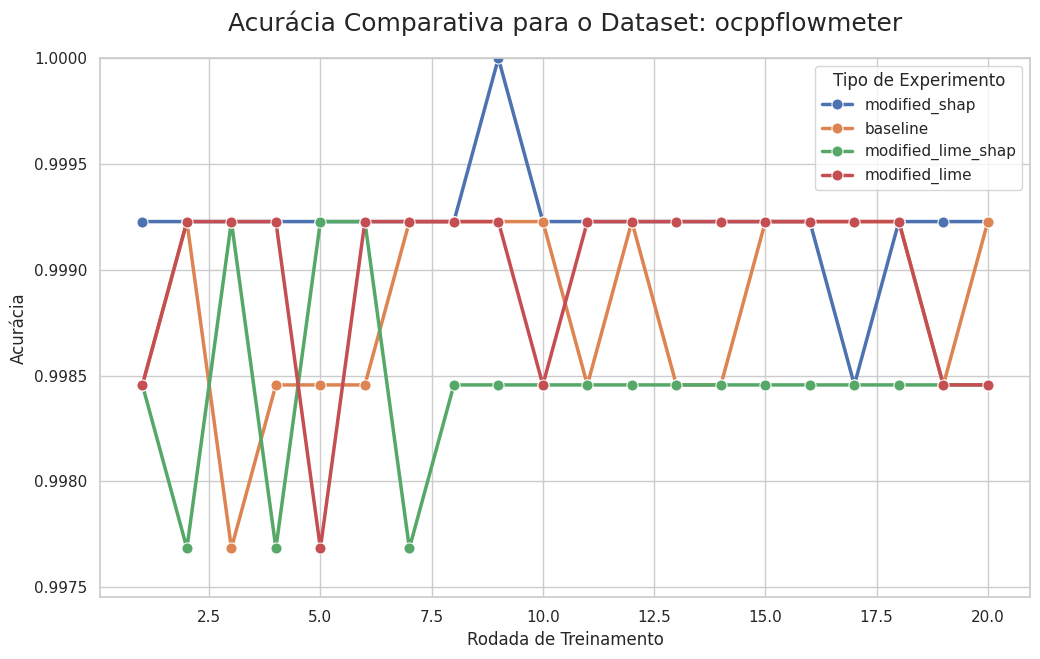

--- Gerando gráfico para: ocppflowmeter | Métrica: Attack_recall ---
Gráfico salvo em: ./notebooks/plots/ocppflowmeter/ocppflowmeter_Attack_recall_comparison.png


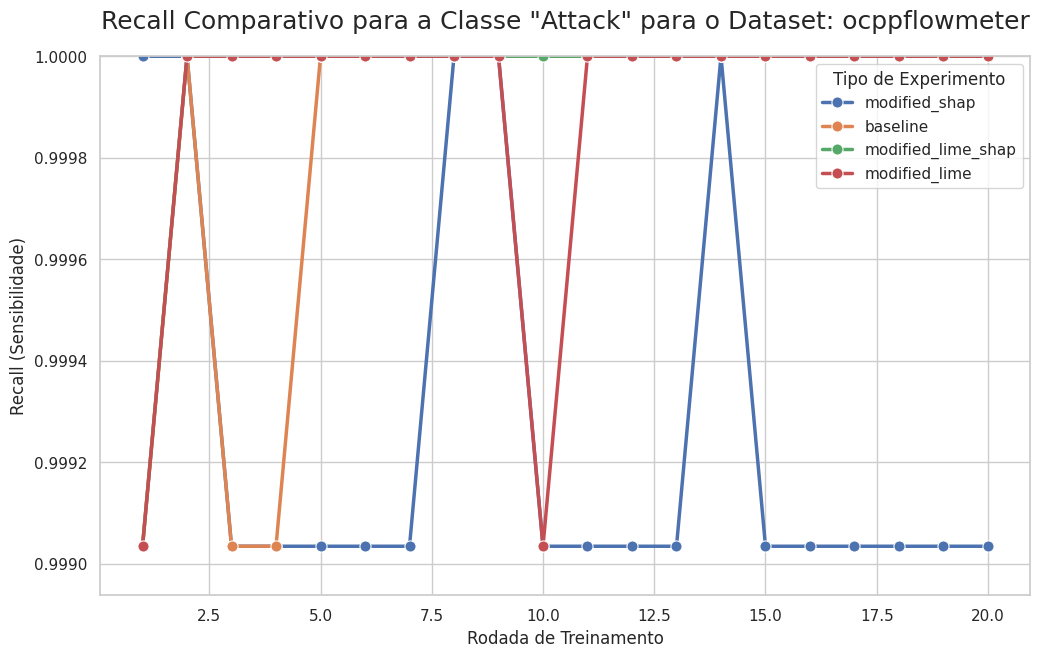

--- Gerando gráfico para: ocppflowmeter | Métrica: Attack_precision ---
Gráfico salvo em: ./notebooks/plots/ocppflowmeter/ocppflowmeter_Attack_precision_comparison.png


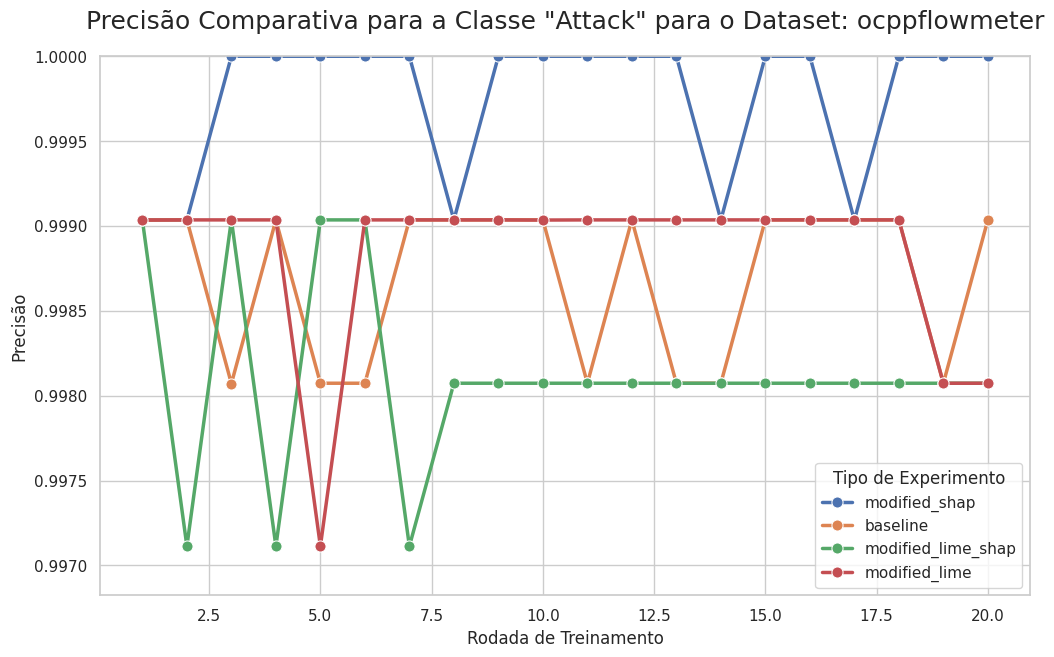

--- Gerando gráfico para: ocppflowmeter | Métrica: macro avg_f1_score ---
Gráfico salvo em: ./notebooks/plots/ocppflowmeter/ocppflowmeter_macro avg_f1_score_comparison.png


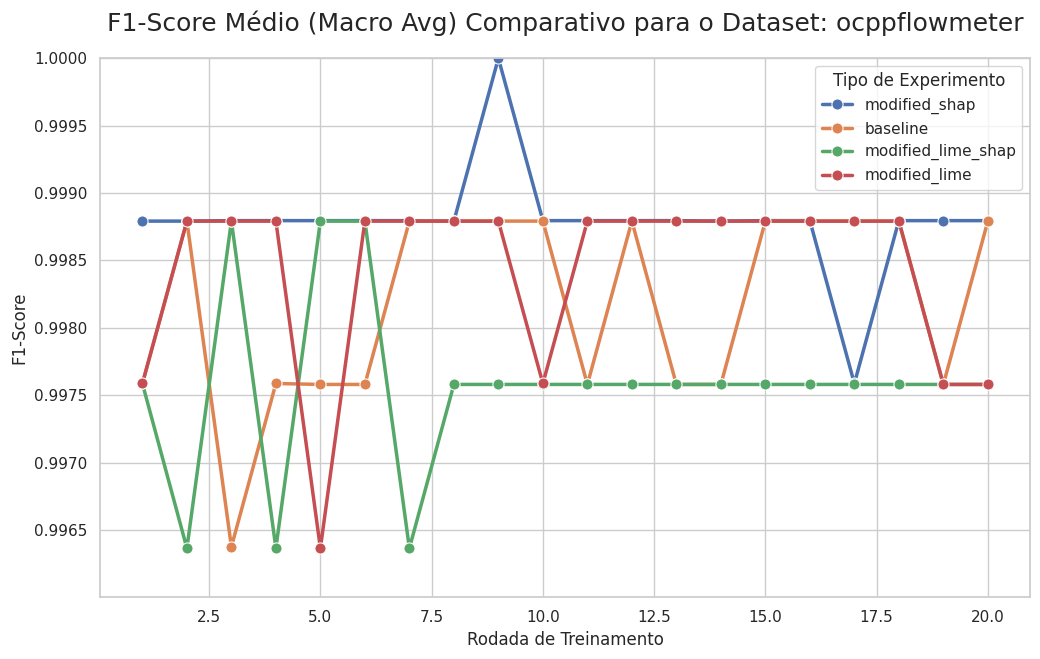


GERANDO GRÁFICOS PARA O DATASET: CICFLOWMETER
--- Gerando gráfico para: cicflowmeter | Métrica: accuracy ---
Gráfico salvo em: ./notebooks/plots/cicflowmeter/cicflowmeter_accuracy_comparison.png


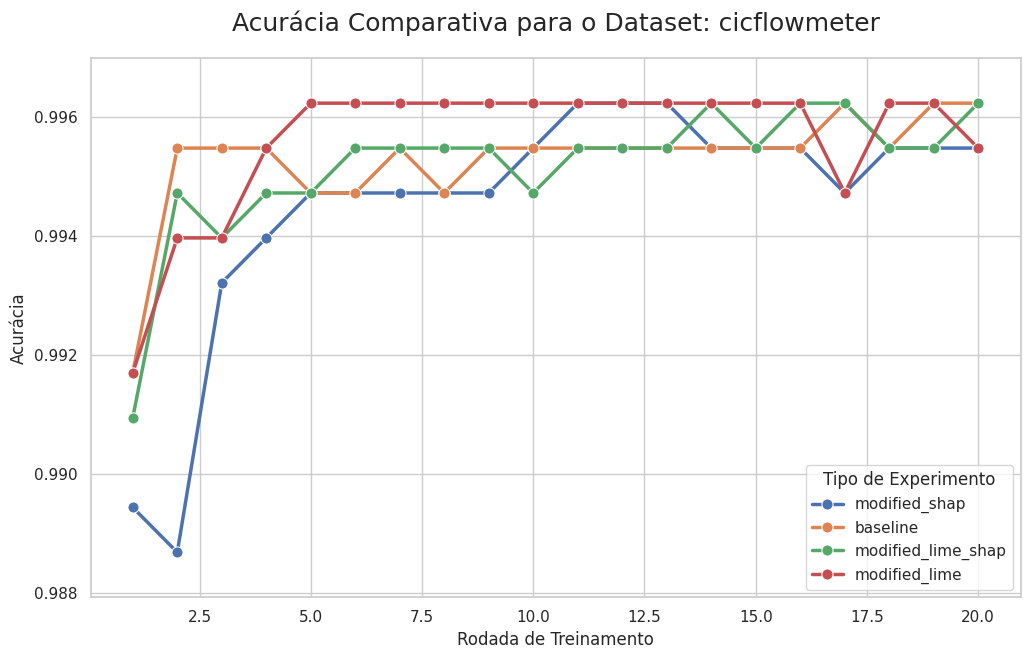

--- Gerando gráfico para: cicflowmeter | Métrica: Attack_recall ---
Gráfico salvo em: ./notebooks/plots/cicflowmeter/cicflowmeter_Attack_recall_comparison.png


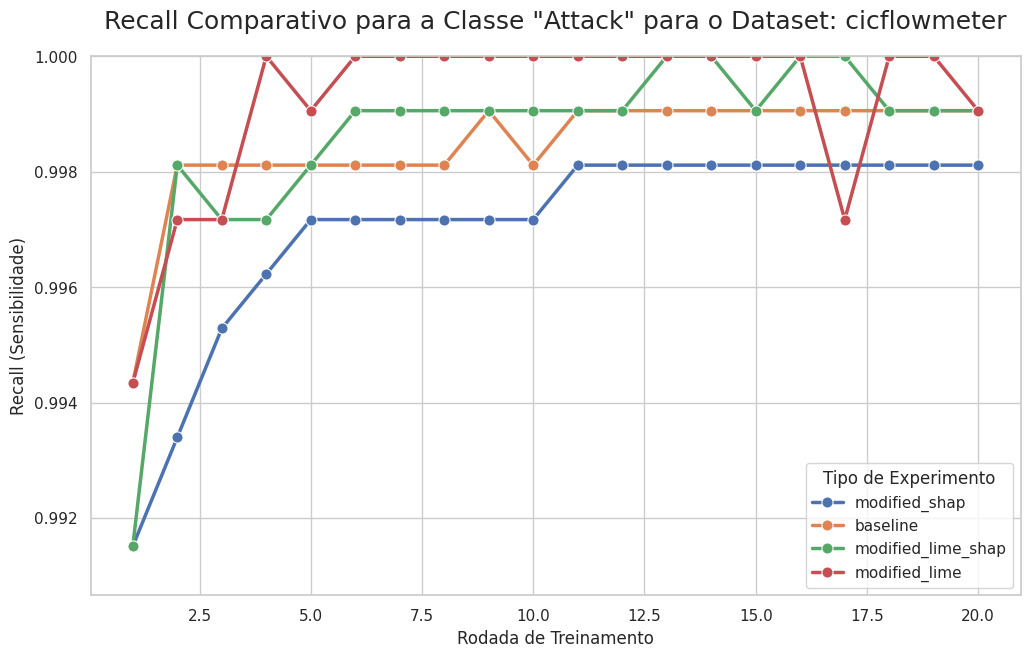

--- Gerando gráfico para: cicflowmeter | Métrica: Attack_precision ---
Gráfico salvo em: ./notebooks/plots/cicflowmeter/cicflowmeter_Attack_precision_comparison.png


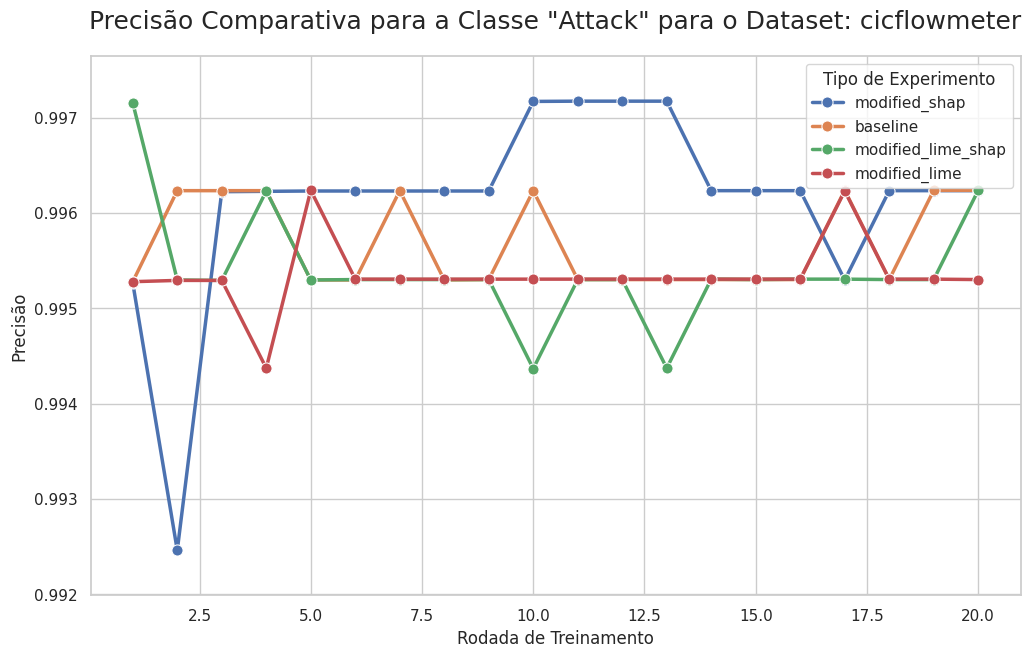

--- Gerando gráfico para: cicflowmeter | Métrica: macro avg_f1_score ---
Gráfico salvo em: ./notebooks/plots/cicflowmeter/cicflowmeter_macro avg_f1_score_comparison.png


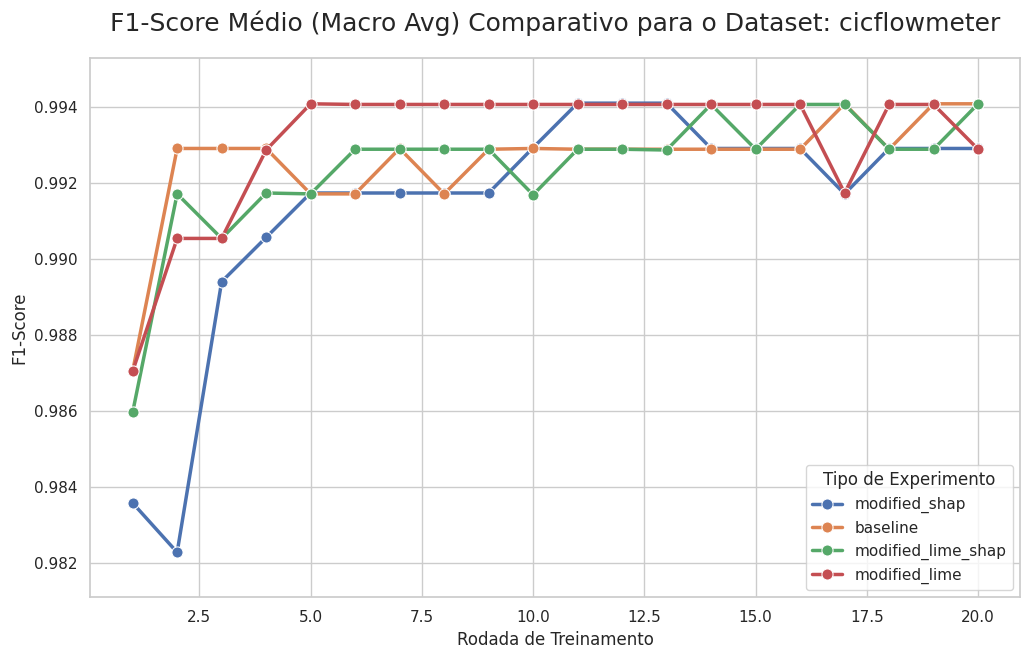

In [35]:
if 'master_metrics_df' in locals():
    # Lista das métricas essenciais para o TCC com os nomes CORRIGIDOS
    metrics_to_plot = [
        {'metric': 'accuracy', 'title': 'Acurácia Comparativa', 'ylabel': 'Acurácia'},
        {'metric': 'Attack_recall', 'title': 'Recall Comparativo para a Classe "Attack"', 'ylabel': 'Recall (Sensibilidade)'},
        {'metric': 'Attack_precision', 'title': 'Precisão Comparativa para a Classe "Attack"', 'ylabel': 'Precisão'},
        {'metric': 'macro avg_f1_score', 'title': 'F1-Score Médio (Macro Avg) Comparativo', 'ylabel': 'F1-Score'}
    ]

    unique_datasets = master_metrics_df['dataset_name'].unique()

    for dataset in unique_datasets:
        print(f"\n========================================================")
        print(f"GERANDO GRÁFICOS PARA O DATASET: {dataset.upper()}")
        print(f"========================================================")
        for metric_info in metrics_to_plot:
            # Verifica se a coluna da métrica existe no DataFrame
            if metric_info['metric'] in master_metrics_df.columns:
                plot_metric_comparison(
                    df=master_metrics_df,
                    dataset_name=dataset,
                    metric_to_plot=metric_info['metric'],
                    title=metric_info['title'],
                    y_label=metric_info['ylabel']
                )
            else:
                print(f"AVISO: A métrica '{metric_info['metric']}' não foi encontrada no DataFrame. Pulando gráfico.")
else:
    print("ERRO: O DataFrame 'master_metrics_df' não foi criado. Execute a célula de carregamento de dados primeiro.")

### analysis 2: feature importance with shap

Generating SHAP plots for all projects...

--- Project: ocpp-ids ---
  -> Generating plot for Exp: baseline, Client: 0


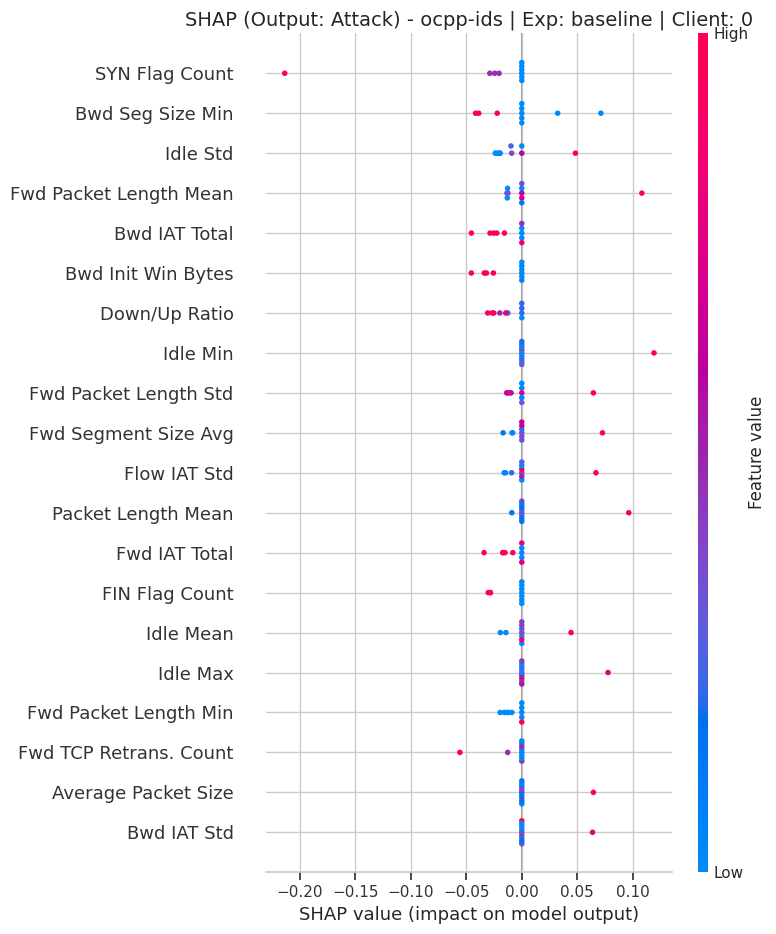

  -> Generating plot for Exp: modified_lime, Client: 0


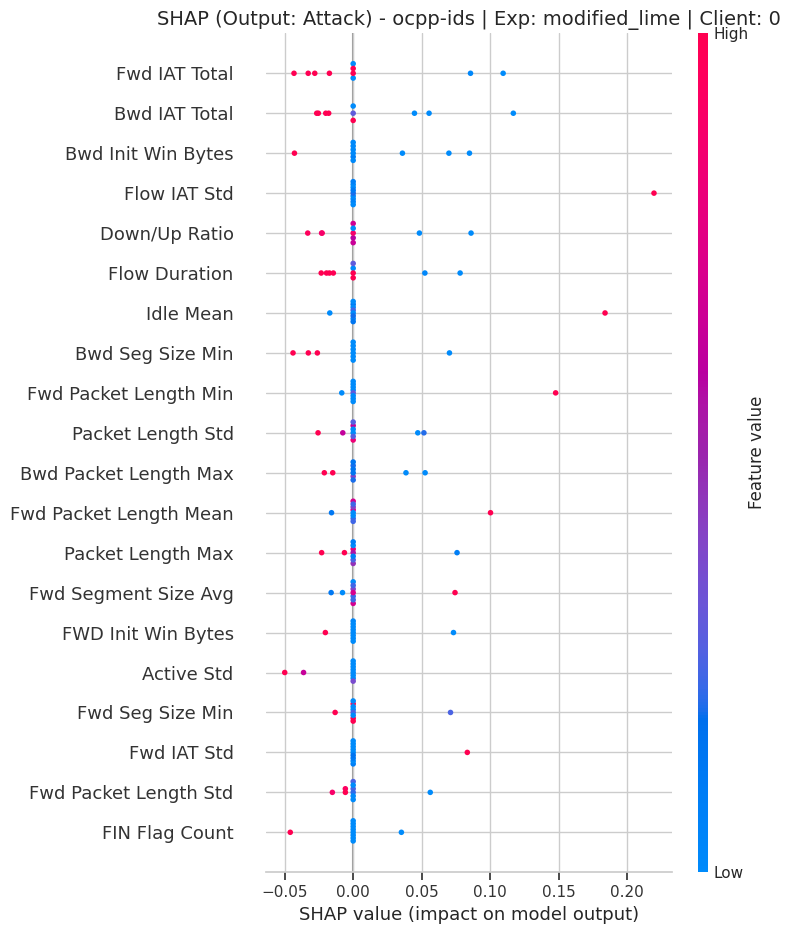

  -> Generating plot for Exp: modified_lime_shap, Client: 0


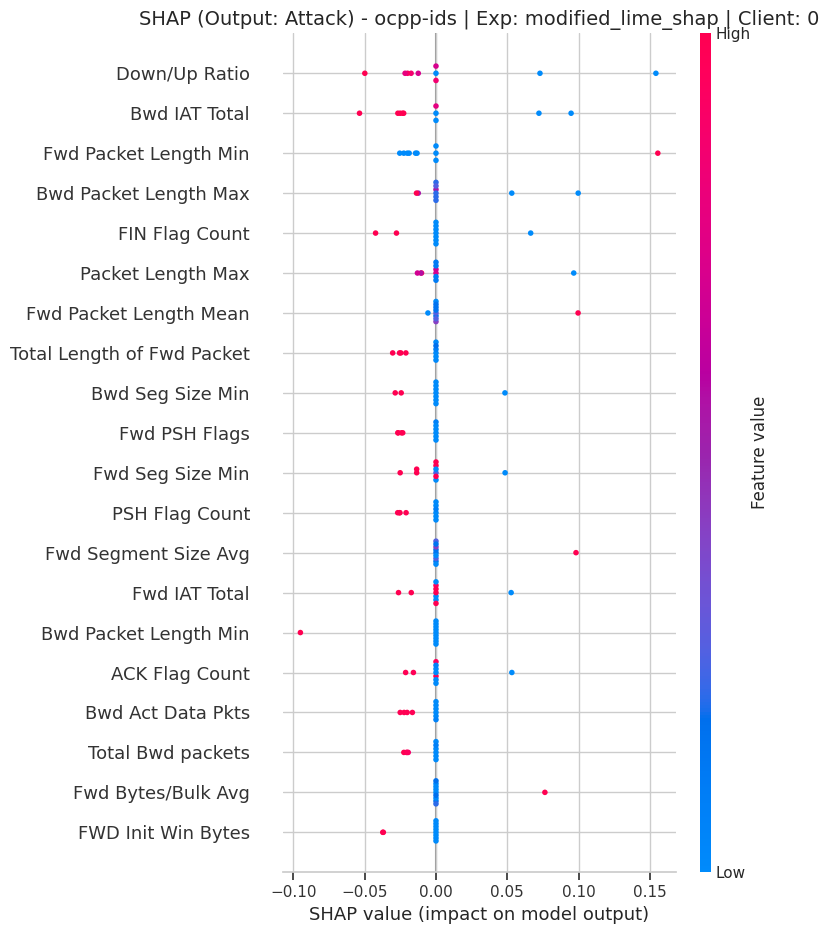

  -> Generating plot for Exp: modified_shap, Client: 0


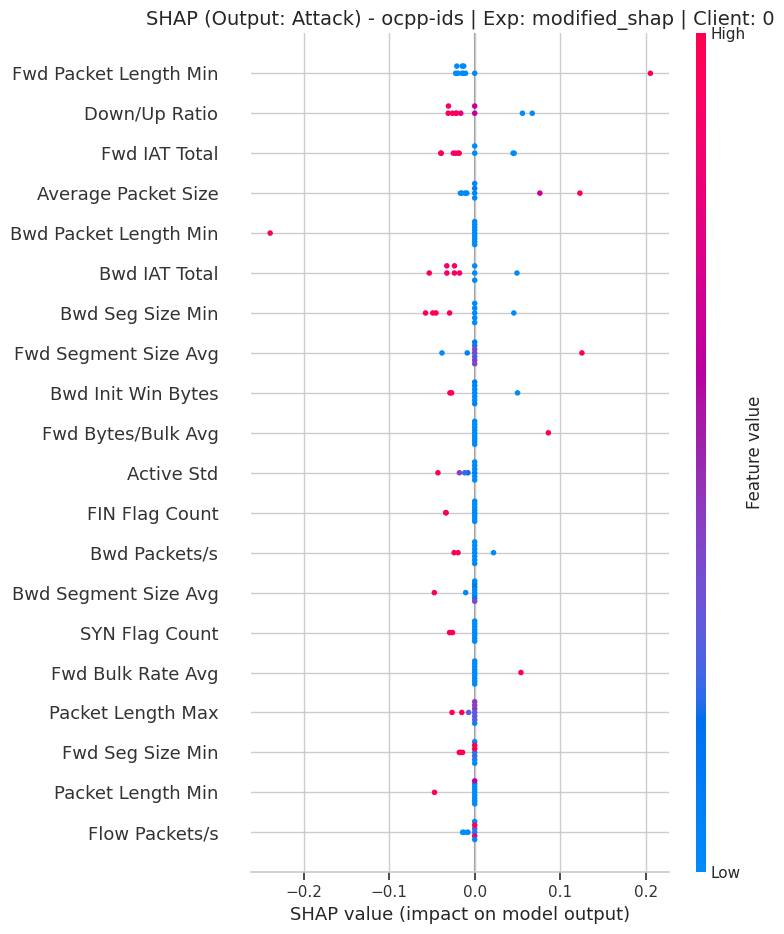

  -> Generating plot for Exp: baseline, Client: 0


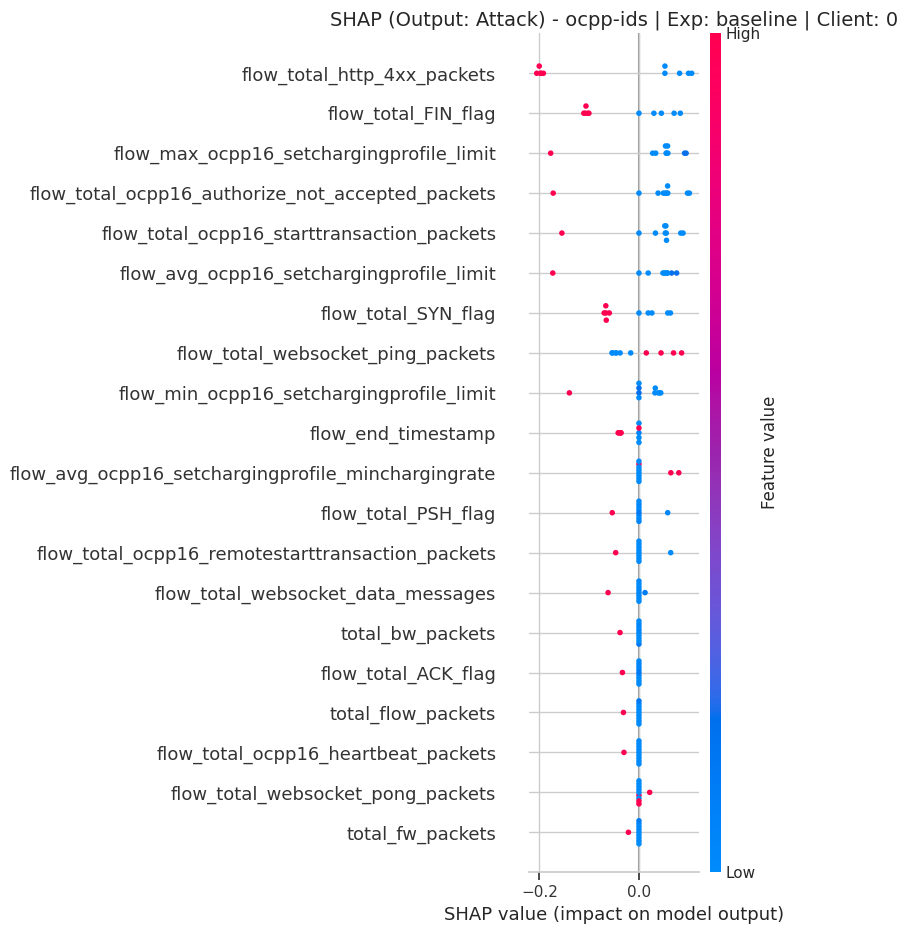

  -> Generating plot for Exp: modified_lime, Client: 0


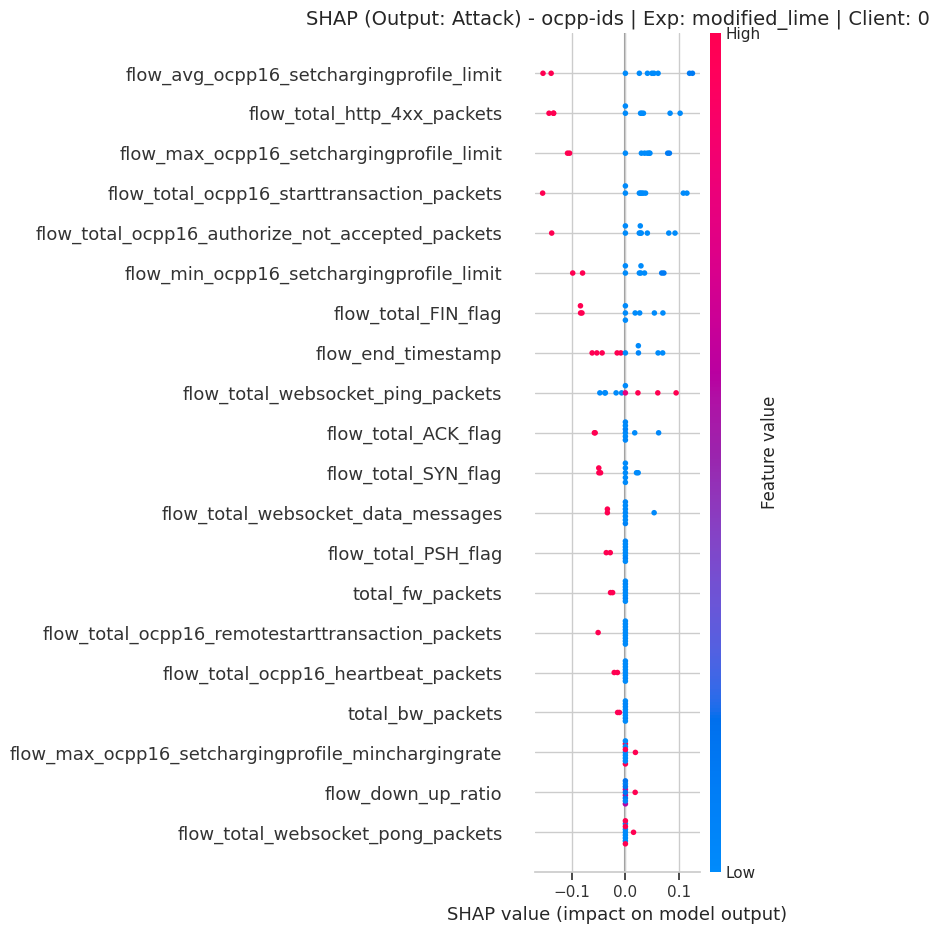

  -> Generating plot for Exp: modified_lime_shap, Client: 0


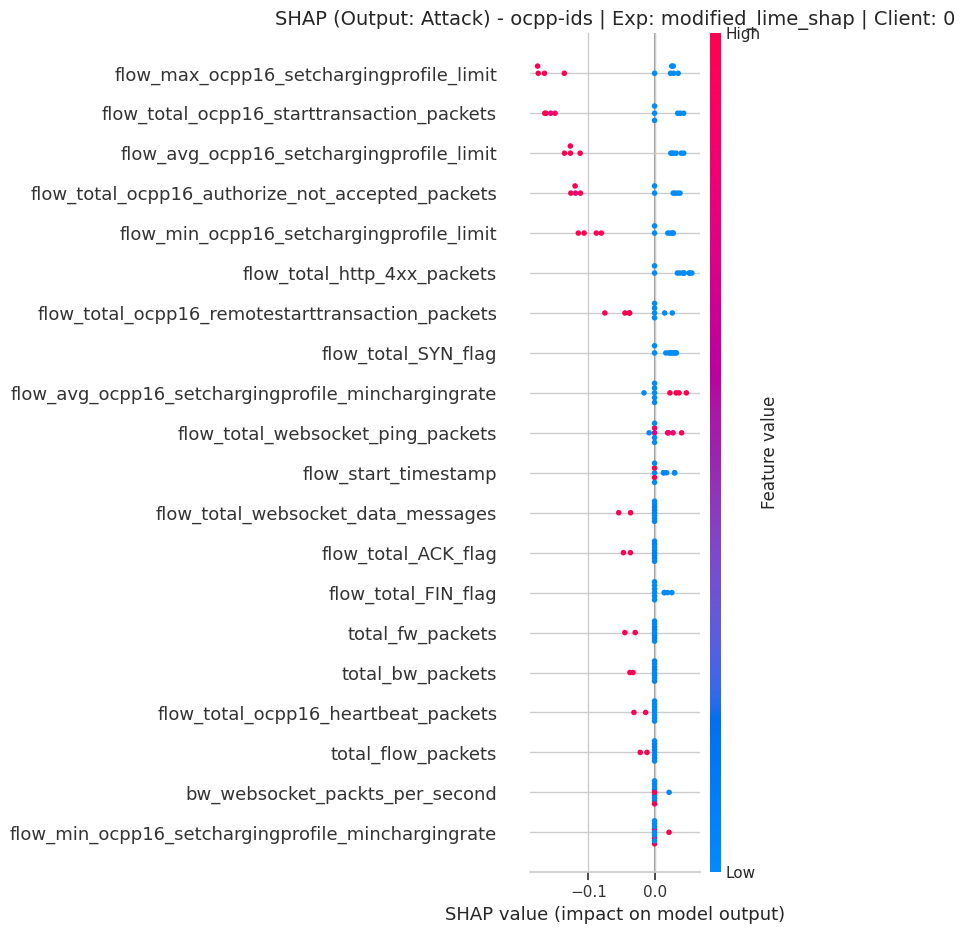

  -> Generating plot for Exp: modified_shap, Client: 0


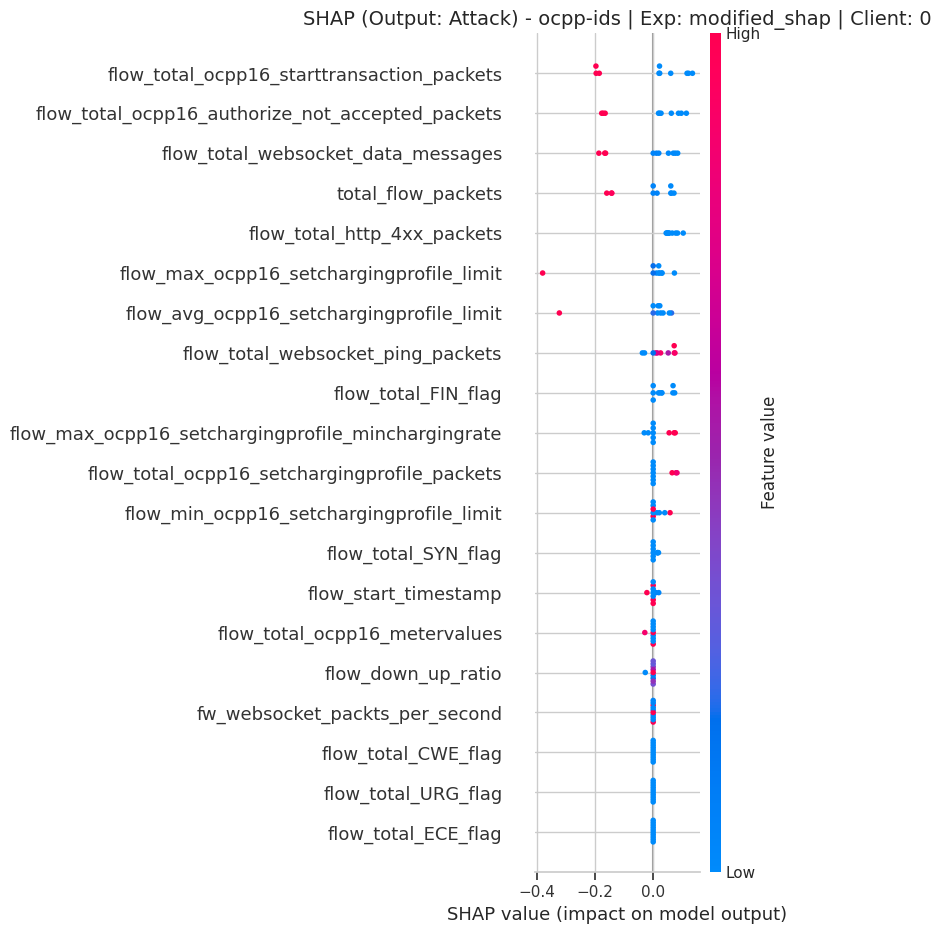

In [36]:
print("Generating SHAP plots for all projects...")
for ids_folder in ids_project_folders:
    print(f"\n--- Project: {ids_folder} ---")
    results_path = os.path.join(ROOT_DIR, ids_folder, 'results')
    
    shap_files = sorted(glob.glob(os.path.join(results_path, '**', 'shap_values_*.npy'), recursive=True))

    if not shap_files:
        print("  -> No SHAP files found.")
        continue

    for shap_file in shap_files:
        try:
            # ... (código para carregar os arquivos continua o mesmo) ...
            parts = shap_file.split(os.sep)
            experiment_type = parts[-3]
            client_number = parts[-1].split('_')[-1].split('.')[0]
            
            shap_dir = os.path.dirname(shap_file)
            data_file = os.path.join(shap_dir, f'shap_data_client_{client_number}.npy')
            features_file = os.path.join(shap_dir, f'shap_features_client_{client_number}.json')

            shap_values = np.load(shap_file, allow_pickle=True)
            data_samples = np.load(data_file, allow_pickle=True)
            with open(features_file, 'r') as f:
                feature_names = json.load(f)

            print(f"  -> Generating plot for Exp: {experiment_type}, Client: {client_number}")
            
            # --- CORREÇÃO APLICADA AQUI PARA MODELO BINÁRIO ---
            # O array shap_values pode ter a forma (amostras, features, 1) ou (amostras, features).
            # Se for 3D, removemos a última dimensão que é de tamanho 1.
            if shap_values.ndim == 3 and shap_values.shape[2] == 1:
                shap_values_to_plot = shap_values[:, :, 0]
            else:
                shap_values_to_plot = shap_values
            
            shap.summary_plot(shap_values_to_plot, data_samples, feature_names=feature_names, show=False)
            
            # O título agora reflete a explicação para a classe 'Attack'
            plt.title(f'SHAP (Output: Attack) - {ids_folder} | Exp: {experiment_type} | Client: {client_number}', fontsize=14)
            plt.tight_layout()
            
            plots_path = os.path.join(ROOT_DIR, 'notebooks', 'plots', ids_folder)
            os.makedirs(plots_path, exist_ok=True)
            plt.savefig(os.path.join(plots_path, f'shap_{experiment_type}_client_{client_number}_binary.png'))
            plt.show()
        except Exception as e:
            print(f"    WARNING: Failed to process {shap_file}. Error: {e}")

### analysis 3: quantitative analysis with LIME

The analysis of LIME results is a manual and qualitative process, done by opening the generated HTML files. You can now compare explanations not only between experiments (`baseline` vs. `modified`) but also between the different IDS models to understand if they "reason" in fundamentally different ways.

**Analysis Workflow:**
1.  Open the HTML reports from `OCPP-IDS/results/baseline/lime/`.
2.  Open the HTML reports from `Another_IDS/results/baseline/lime/`.
3.  Compare them. For the same type of attack (if applicable), do the two IDS models use the same features to justify their decisions? This analysis can reveal much about the nature of each model.